# Les inn NetCDF-fil

vi har lastet ned en netcf fil fra https://www.esrl.noaa.gov/psd/data/composites/day/ og kalt den `NOAA_reanalysis.nc`. For å lese netCDF filer liker jeg best å bruke `xarray`, og for å plott kart liker jeg `cartopy`. 

In [21]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [194]:
da = xr.open_dataset('NOAA_reanalysis.nc')

In [195]:
display(da)

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 144, time: 1)
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 2020-02-17
Data variables:
    hgt      (time, lat, lon) float32 ...
Attributes:
    title:        Composite Anomaly
    history:      Created via daily composite webtool at NOAA/ESRL PSD
    description:  Computed from the web page http://www.esrl.noaa.gov/psd/dat...
    Conventions:  COARDS

her ser vi at da sine breddegrader går fra 90 til -90. Jeg liker best å ha de andre veien. Dette er enkelt å fikse hvis vi bare sorterer breddegradene våre etter størrelse. I tillegg liker jeg best å ha koordinatene mine i lon fra -180 til 180. Det er litt mer komplisert. Men heldigvis er det mange som liker å gjøre det på denne måten, derfor har `xarray` en egen funksjonalitet. Les mer på http://xarray.pydata.org/en/stable/generated/xarray.DataArray.assign_coords.html. Og etterpå shifter vi alle koordinatene våre så Stillehavet havner på enden, mens Atlanteren på midten.  

In [209]:
da2 = (da.sortby('lat') #sorterer etter breddegrader
       .assign_coords({'lon' : (((da.lon + 180) % 360) - 180)}) #gjør om koordinatene 
       .roll(lon = -360,roll_coords=True)) # roterer systemet

In [210]:
da2

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 144, time: 1)
Coordinates:
  * lat      (lat) float32 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0
  * lon      (lon) float32 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * time     (time) datetime64[ns] 2020-02-17
Data variables:
    hgt      (time, lat, lon) float32 -27.13 -27.13 -27.13 ... -141.0 -141.0
Attributes:
    title:        Composite Anomaly
    history:      Created via daily composite webtool at NOAA/ESRL PSD
    description:  Computed from the web page http://www.esrl.noaa.gov/psd/dat...
    Conventions:  COARDS

først må vi velge oss ut området vi skal plotte; som er lon = [-100,50], og lat = [20,80]. Det er veldig enkelt i xarray hvor vi kan bruke `da.sel`

In [216]:
da_at = da2.sel(lat=slice(20,80),lon=slice(-100,50))

In [217]:
da_at

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 61, time: 1)
Coordinates:
  * lat      (lat) float32 20.0 22.5 25.0 27.5 30.0 ... 70.0 72.5 75.0 77.5 80.0
  * lon      (lon) float32 -100.0 -97.5 -95.0 -92.5 ... 42.5 45.0 47.5 50.0
  * time     (time) datetime64[ns] 2020-02-17
Data variables:
    hgt      (time, lat, lon) float32 2.667 -0.1501 -2.784 ... -110.0 -104.3
Attributes:
    title:        Composite Anomaly
    history:      Created via daily composite webtool at NOAA/ESRL PSD
    description:  Computed from the web page http://www.esrl.noaa.gov/psd/dat...
    Conventions:  COARDS

og da kan vi plotte området vårt og geopotensial-høyden

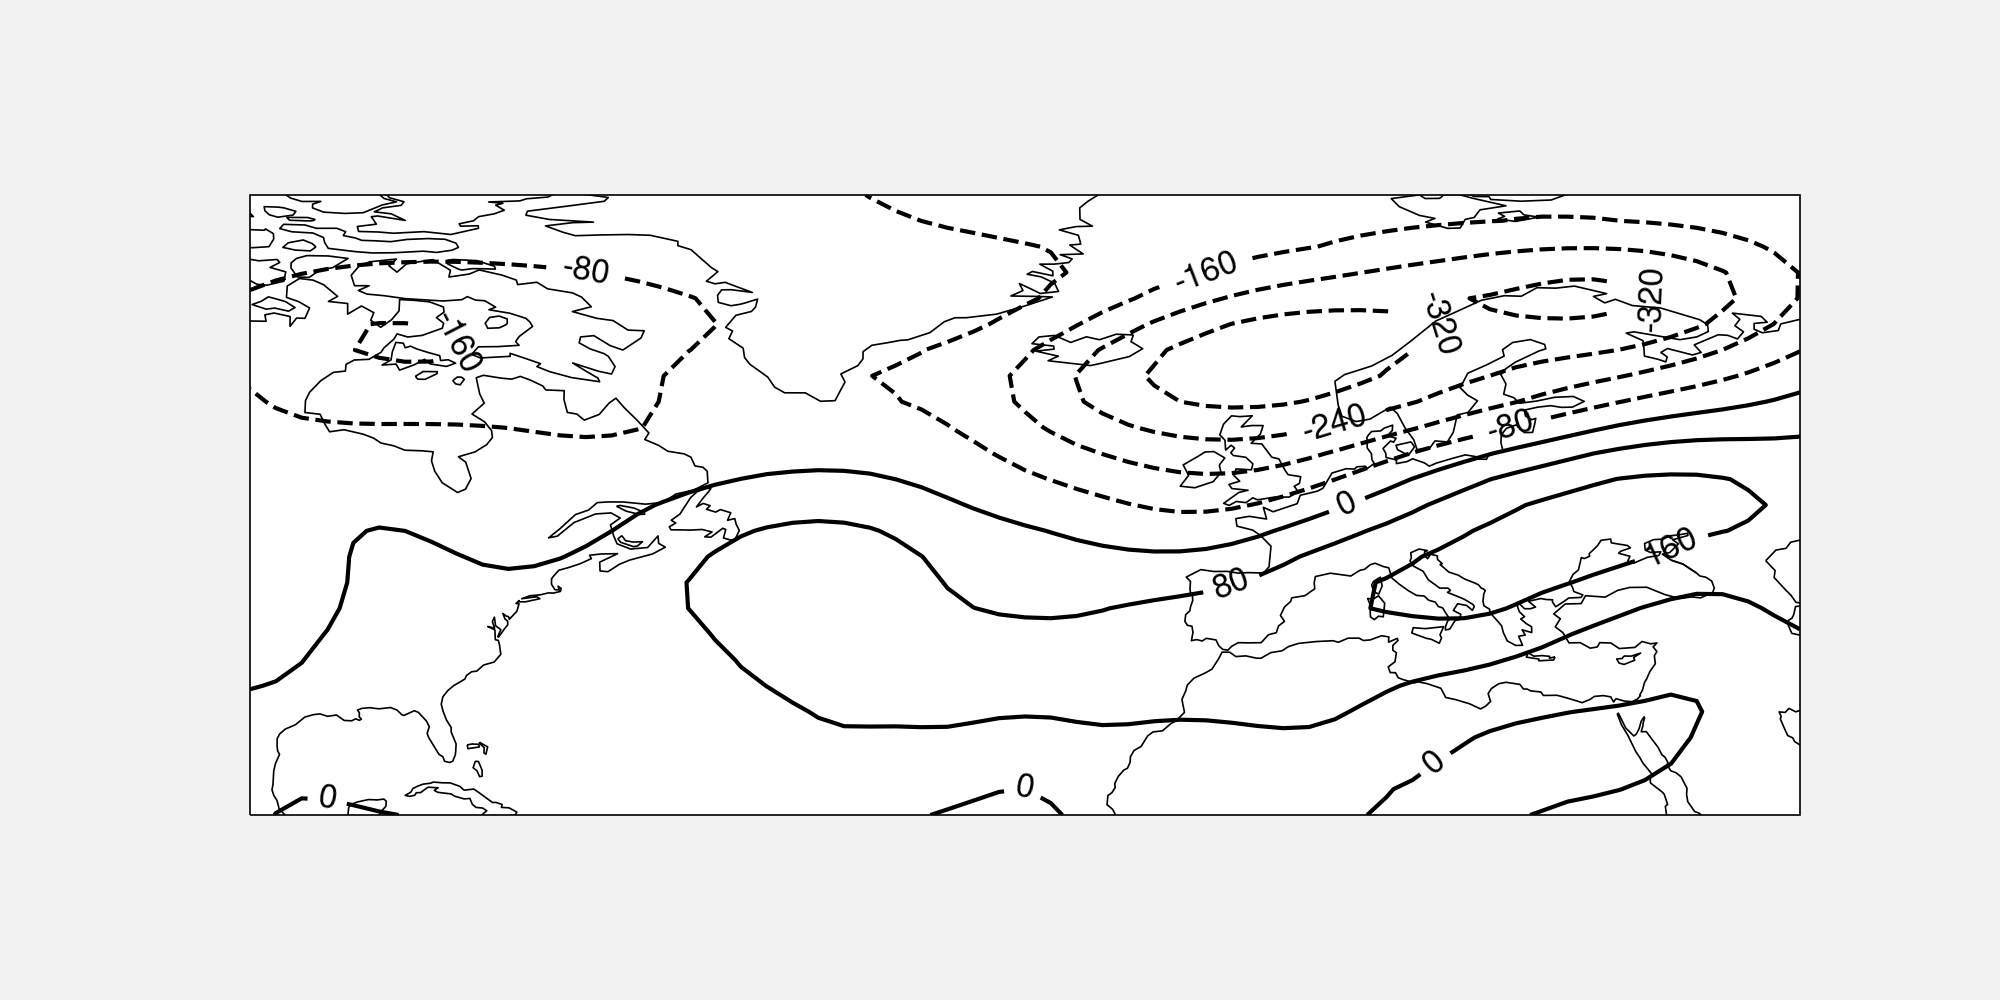

In [227]:
plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_ylim([20,80])
ax.set_xlim([-100,50])

contour = ax.contour(da_at.lon,da_at.lat,da_at.hgt.values.squeeze(),colors='k')
ax.clabel(contour,fmt='%1.0f',fontsize=12)


plt.show()


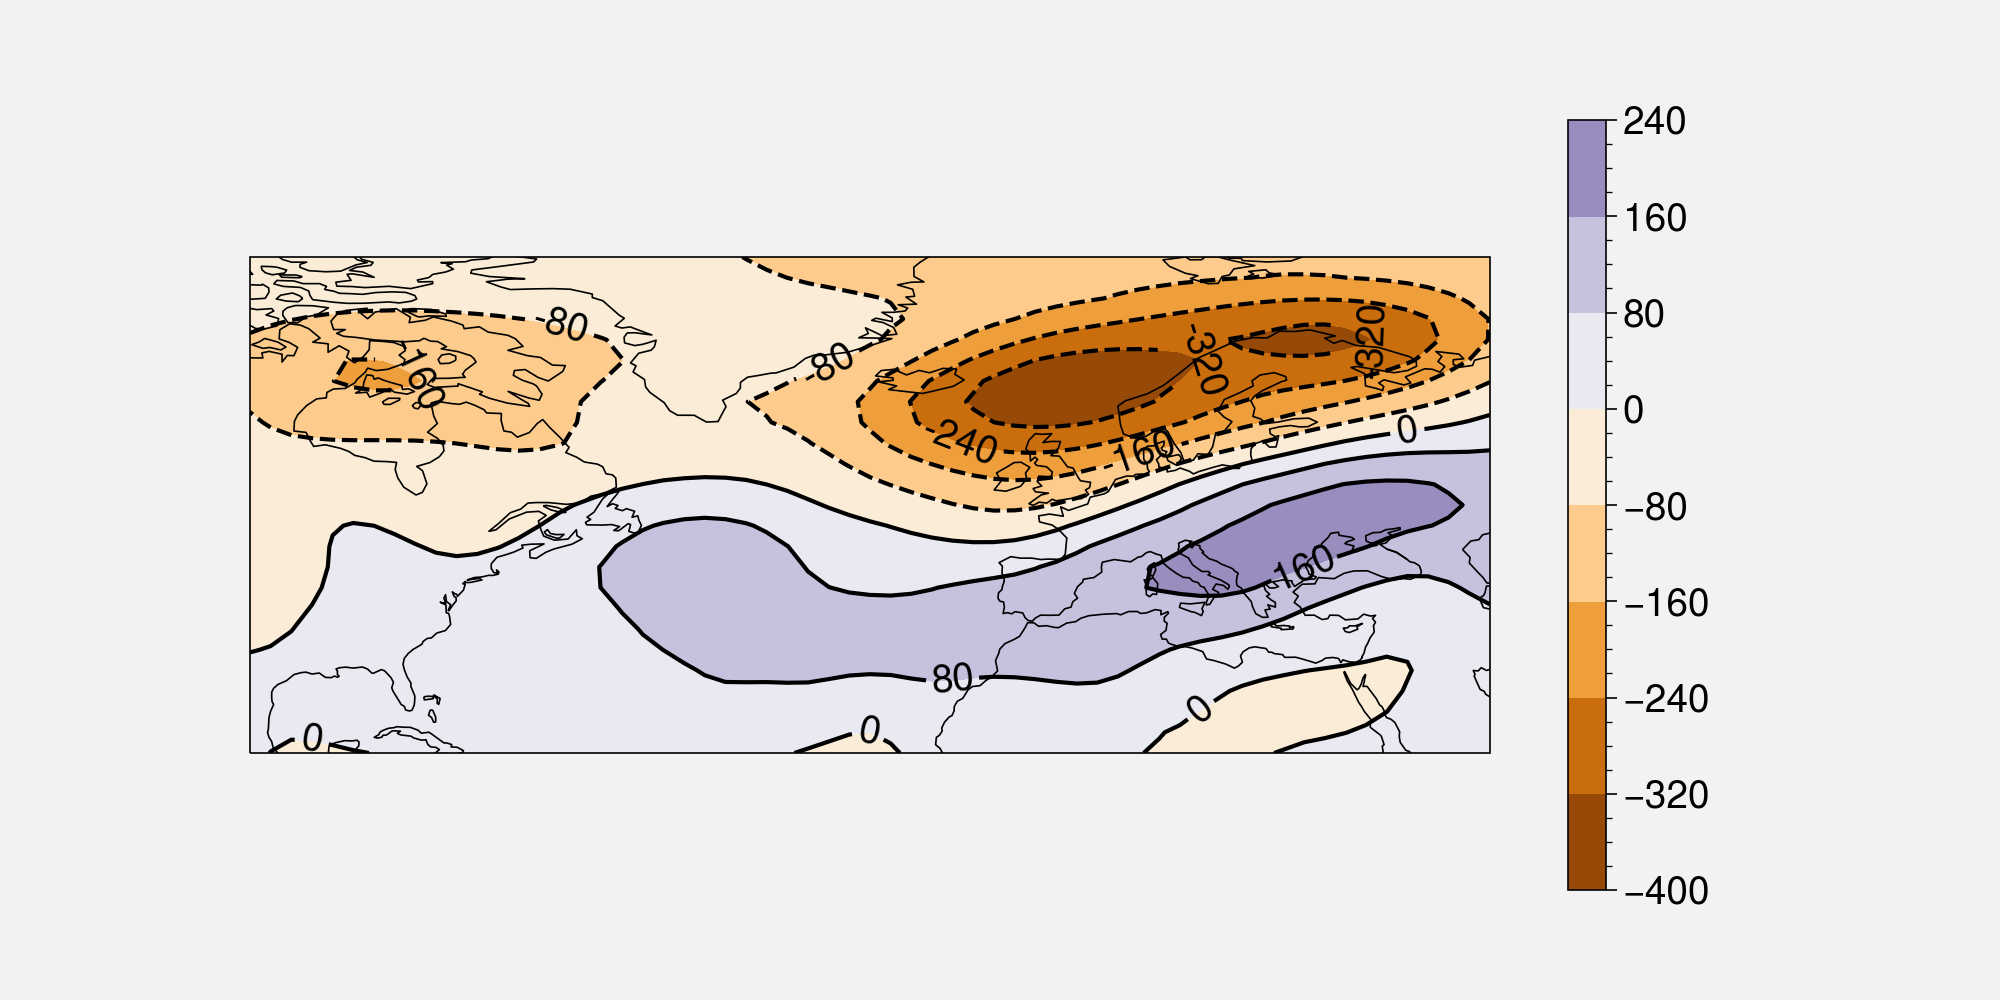

In [228]:
plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_ylim([20,80])
ax.set_xlim([-100,50])

c = ax.contourf(da_at.lon,da_at.lat,da_at.hgt.values.squeeze(),
                     cmap='PuOr',vmax=400,vmin=-400)
contours = ax.contour(da_at.lon,da_at.lat,da_at.hgt.values.squeeze(),colors='k')
ax.clabel(contours,fmt = '%1.0f')
plt.colorbar(c)


plt.show()

egentlig når jeg plotter liker jeg for det meste å bruke `proplot`. Iallfall på kart. Det synes jeg er litt mer intuitivt. Det bygger på matplotlib, så det meste av funksjonaliteten er den samme. 

/home/kko033/anaconda3/envs/extreme_precip/lib/python3.7/site-packages/proplot/figure.py:1158: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  return super().colorbar(*args, cax=cax, **kwargs)


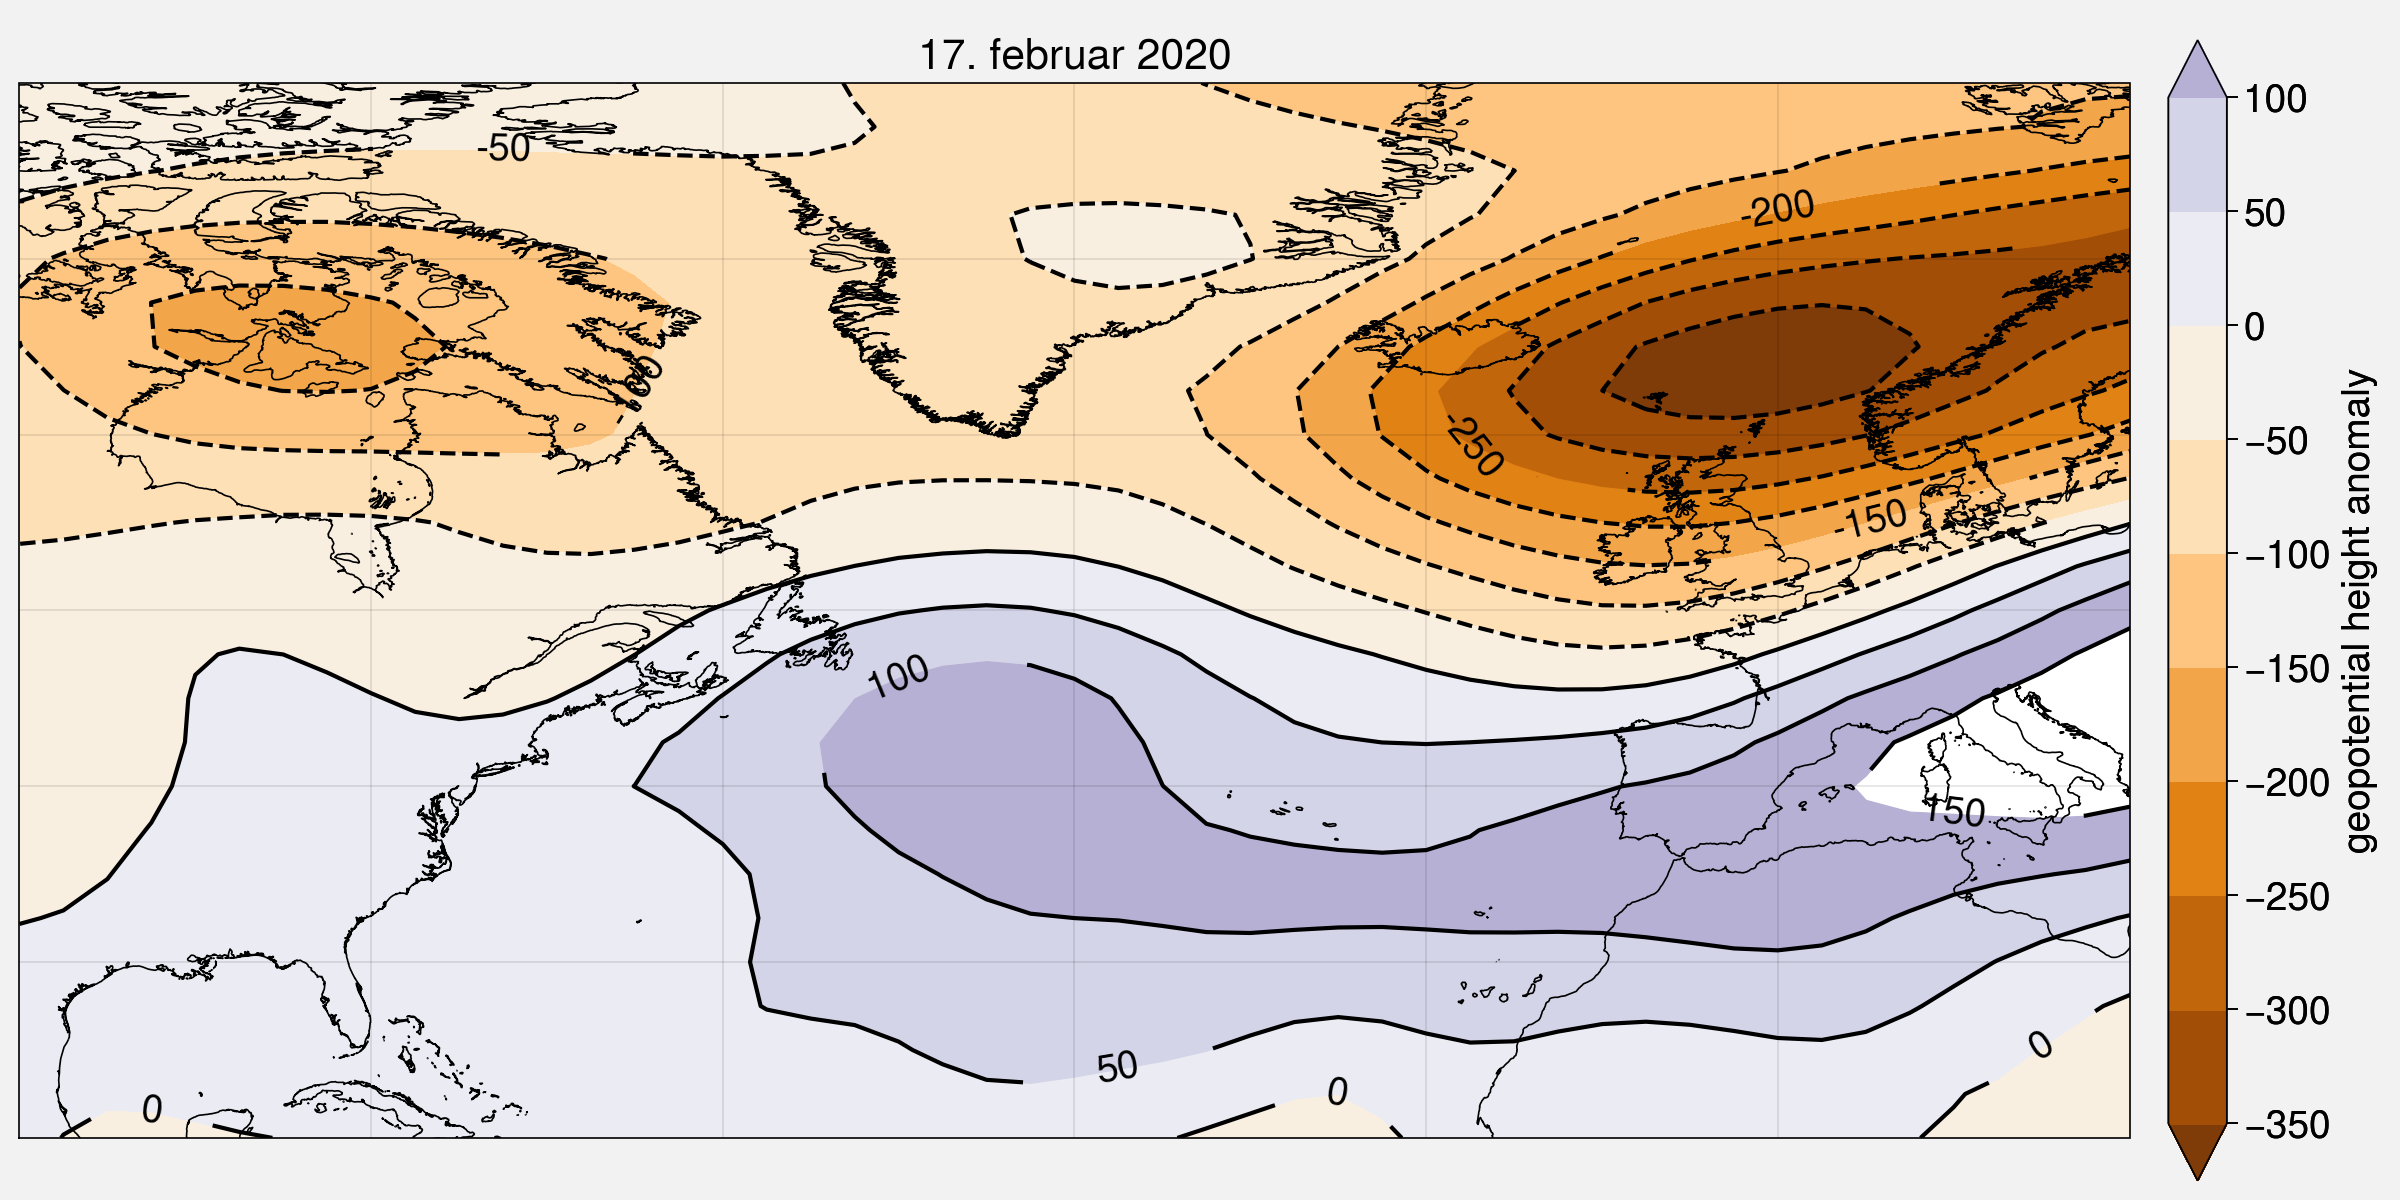

In [220]:
import proplot as plot
import numpy as np

plot.rc['font.size'] = 14

fig,ax = plot.subplots(projection=ccrs.PlateCarree(),figsize=(12,6))
levels = np.arange(-400,200,50)

c = ax.contourf(da_at.lon,da_at.lat,da_at.hgt.values.squeeze(),
                     cmap='PuOr',norm='diverging',levels=levels)
contours = ax.contour(da_at.lon,da_at.lat,da_at.hgt.values.squeeze(),colors='k',levels=levels)
ax.clabel(contours,fmt = '%1.0f',fontsize=14)
ax.format(latlim=[20,80],lonlim=[-100,20],coast=True,reso='hi',title='17. februar 2020')

fig.colorbar(c,extend='both',label='geopotential height anomaly')
